# Adaptive Frank-Wolf method for Relative-Error problems
## Problem formulation

PageRank[1] problem for Frank-Wolf methods is shown below:

$$
f(x) = \frac{1}{2}\left\lVert{Ax}\right\rVert_2^2 \to \min_{x\in\Delta^n_{1}}
$$

, where:

$$
A = I - P^\intercal
$$

$I$ – identity matrix of size $n\times n$, $P$ – stochastic transit matrix, $P \in \R^{n\times n}$

Gradient of the given function is represented below:

$$
\nabla f(x) = A^\intercal A x
$$

[1]: Efficient numerical methods to solve sparse linear equations with application to PageRank, Anikin A., Gasnikov A., et al, 2022


#  Implementation of Adaptive Frank-Wolfe algorithm with Erroneous Conditional Oracle

In [8]:
import numpy as np

# Visualization
import matplotlib.pyplot as plt

In [9]:
from aecg import AECG
from helper import Objective, PageRankObjective
from helper import BoxSetLMO
from helper import CWEOracle
from helper import StepSizeStrategy

# Configure `seed` for reproducibility of the solution
np.random.seed(2024)

# Size of the problem
n = 100

# Relative Error [0; 0.5)
eps = 1e-14

# Objective parameters
A = np.random.randn(n, n)
A = A / A.sum(axis=1, keepdims=True)  # Normalize rows for PageRank

# Box Set properties
lower_bound = np.zeros(n)
upper_bound = np.ones(n)

# Objective function
objective = PageRankObjective(A)

# Number of iterations
max_iterations = 1_000

# Coordinate-wise erroneous oracle
erroneous_oracle = CWEOracle(epsilon=eps)

# Linear minimization oracle
linear_minimization_oracle = BoxSetLMO(lower_bound=lower_bound, upper_bound=upper_bound)

# Starting point
w0 = np.random.uniform(lower_bound, upper_bound)


# Helper function for creating algorithm with given step size.
def create_algorithm(label: str, step_size: StepSizeStrategy) -> AECG:
    return AECG(
        label=label,
        max_iterations=max_iterations,
        objective=objective,
        eo=erroneous_oracle,
        lmo=linear_minimization_oracle,
        step_size=step_size,
        keep_history=True,
    )

## Scenario with iteration-dependent step-size.

Let the step size is dependent on iteration number $t$:

$$
\eta_t = \min(1, \frac{2}{t + 2}),

\forall t \geqslant 0
$$

**Convergence rate:**

$$
f^t - f^* \leqslant \varepsilon M R + \frac{4\max_{t}L_t \cdot R^2}{t + 2}
$$

, where

$$
L_t = \frac{2 \cdot (f^{t+1} - f^t - {\eta_t\langle \hat{g^t}, p^{t+1} \rangle})}{\eta_t^2\lVert p^{t + 1}\rVert^2}
$$

## Case 1. $L_t \geqslant L$

**Stopping criterion:**

$$
f^{t + 1} - f^* \leqslant f^t - f^{*} + \frac{2}{t+2} \langle\hat{g^t}, p^{t+1}\rangle + \frac{2\varepsilon M R}{t + 2} + \frac{4\max\limits_t{L_t} \cdot R^2}{(t + 2)^2}
$$

In [10]:
from helper import DynamicDecayingStepSizeStrategy

step_size_strategy = DynamicDecayingStepSizeStrategy(epsilon=eps)

In [11]:
# Solve for iteration dependent step size
from helper import ConstantDecayingStepSizeStrategy

# Lipschitz-gradient constant
L = np.linalg.eigvals(A).max()
L


class StepSizeWrapper:
    """
    A wrapper for |DecayingStepSizeStrategy| to print table of
    intermediate results.
    """

    _L: float
    _wrappee: StepSizeStrategy

    def __init__(self, wrappee: StepSizeStrategy, L: float):
        self._wrappee = wrappee
        self._L = L
        self._print_table(r"$    t     L_t    L$")

    def __call__(
        self,
        t: int,
        g_hat: np.ndarray,
        p: np.ndarray,
    ) -> float:
        return self._wrappee(t, g_hat, p)

    def is_stop_criterion_reached(
        self,
        t: int,
        objective: Objective,
        w: np.ndarray,
        w_next: np.ndarray,
        f_opt: np.ndarray,
        g_hat: np.ndarray,
        p: np.ndarray,
    ) -> bool:
        result = self._wrappee.is_stop_criterion_reached(
            t, objective, w, w_next, f_opt, g_hat, p
        )
        self._print_table(f"{t:6d} {self._wrappee._Lt:10.3e} {self._L:10.1f}")
        return result

    def _print_table(self, row: str):
        if False:
            print(row)


dynamic_algorithm = create_algorithm(
    label=r"$L_t \geqslant L$",
    step_size=StepSizeWrapper(DynamicDecayingStepSizeStrategy(eps), L),
)

w = dynamic_algorithm.solve(w0)
w

Converged at iteration 1
Converged at 1


array([0.72738104, 0.21752066, 0.44813307, 0.80084264, 0.49710958,
       0.65625793, 0.01083227, 0.69826962, 0.28812682, 0.44267208,
       0.3436302 , 0.49242617, 0.9643121 , 0.42916171, 0.67704561,
       0.90549182, 0.65166883, 0.49955901, 0.14374969, 0.94313082,
       0.35740079, 0.74105271, 0.52195691, 0.11352492, 0.62955456,
       0.90497551, 0.00949455, 0.36024409, 0.18100202, 0.52659881,
       0.47389896, 0.18024034, 0.5402871 , 0.25572859, 0.19625886,
       0.46555455, 0.22518198, 0.25169045, 0.75726425, 0.75611579,
       0.30294883, 0.53626474, 0.27020568, 0.32728079, 0.14432729,
       0.92618548, 0.55695279, 0.44151596, 0.65761016, 0.15519933,
       0.50578893, 0.18892948, 0.50663377, 0.01737619, 0.17257178,
       0.92645422, 0.91261036, 0.00432907, 0.64597179, 0.63615024,
       0.27251267, 0.24927924, 0.59342101, 0.55384383, 0.85690835,
       0.07766177, 0.79704071, 0.43056815, 0.66897392, 0.46602987,
       0.70767545, 0.77315628, 0.82737128, 0.38328771, 0.33323

## Case 2. $L_t \leqslant c \cdot L$

In [12]:
constant_algorithm = create_algorithm(
    label=r"$L_t \leqslant c \cdot L$",
    step_size=StepSizeWrapper(ConstantDecayingStepSizeStrategy(eps, 2 * L), L),
)

w = constant_algorithm.solve(w0)
w

Converged at iteration 77
Converged at 77


array([0.50649351, 0.50649351, 0.50649351, 0.50649351, 0.49350649,
       0.49350649, 0.50649351, 0.50649351, 0.50649351, 0.50649351,
       0.49350649, 0.49350649, 0.49350649, 0.50649351, 0.50649351,
       0.49350649, 0.50649351, 0.50649351, 0.49350649, 0.49350649,
       0.50649351, 0.49350649, 0.50649351, 0.49350649, 0.50649351,
       0.50649351, 0.49350649, 0.49350649, 0.50649351, 0.50649351,
       0.49350649, 0.49350649, 0.50649351, 0.50649351, 0.50649351,
       0.49350649, 0.49350649, 0.49350649, 0.50649351, 0.50649351,
       0.50649351, 0.49350649, 0.50649351, 0.49350649, 0.49350649,
       0.49350649, 0.49350649, 0.50649351, 0.50649351, 0.49350649,
       0.49350649, 0.49350649, 0.50649351, 0.50649351, 0.50649351,
       0.49350649, 0.49350649, 0.49350649, 0.49350649, 0.50649351,
       0.50649351, 0.50649351, 0.49350649, 0.49350649, 0.49350649,
       0.50649351, 0.49350649, 0.49350649, 0.49350649, 0.49350649,
       0.50649351, 0.49350649, 0.50649351, 0.50649351, 0.50649

## Results

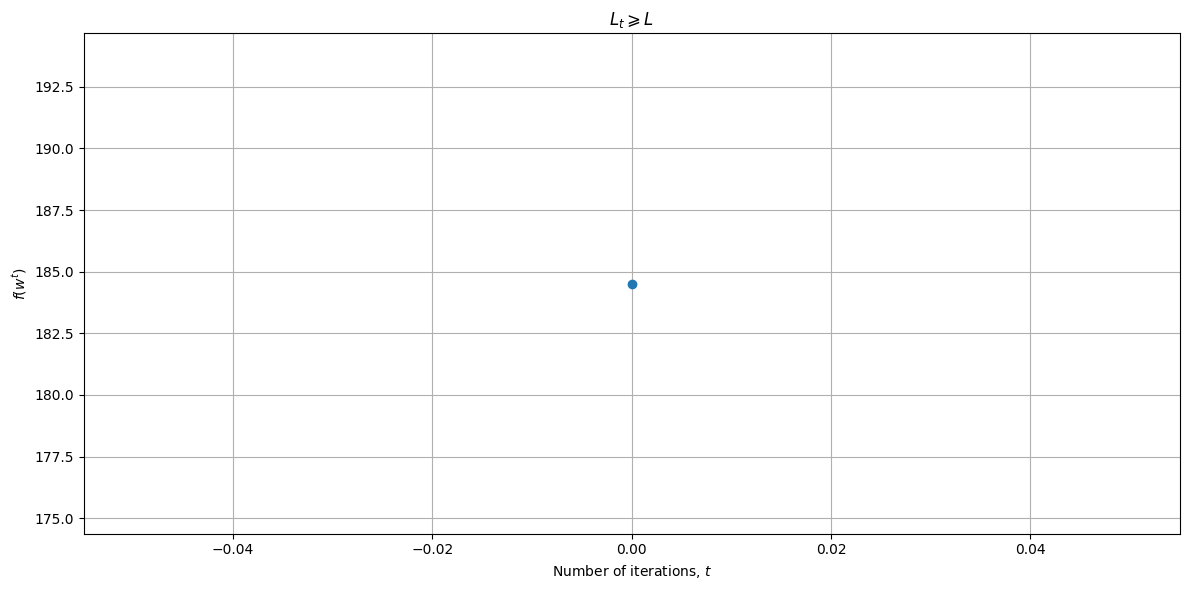

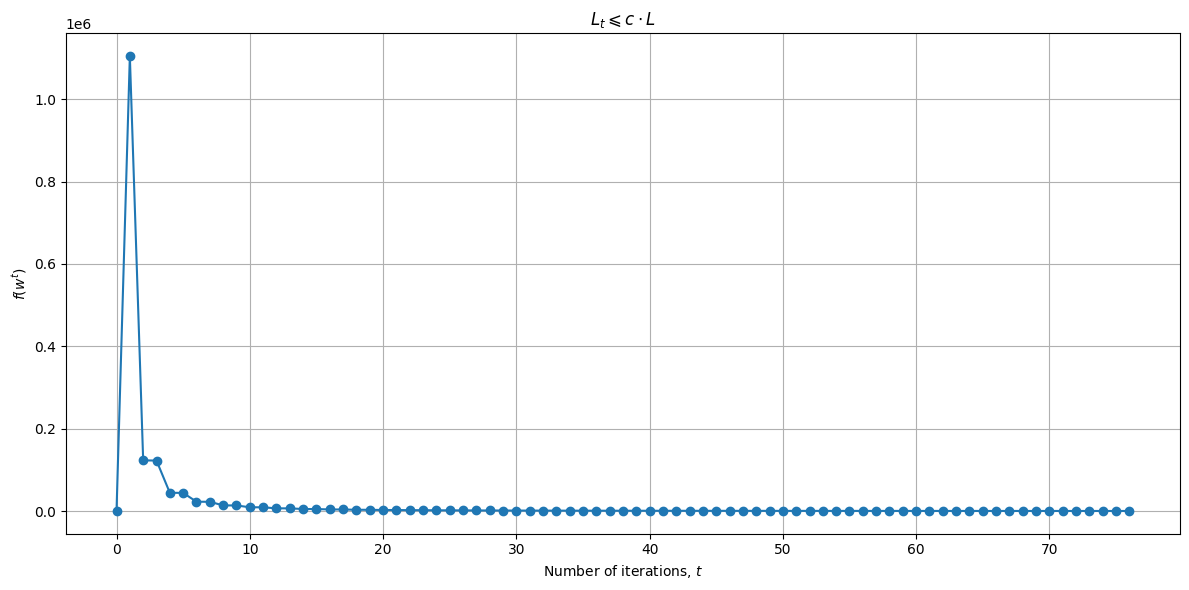

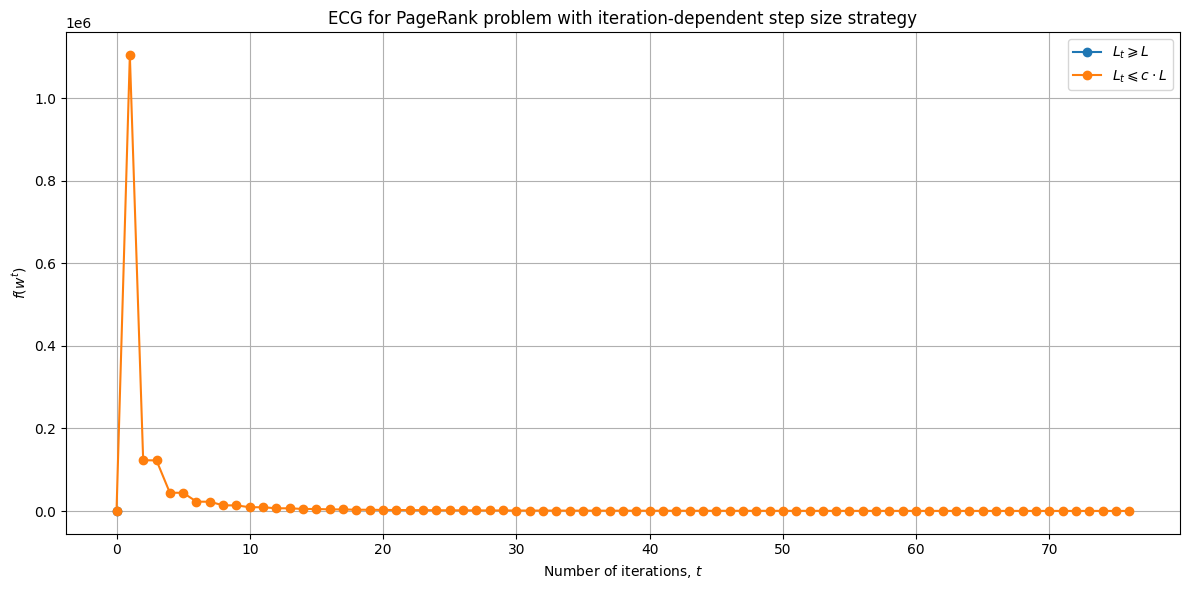

In [13]:
algorithms = [dynamic_algorithm, constant_algorithm]

# Comparison of results

for algorithm in algorithms:
    plt.figure(figsize=(12, 6))
    values = [objective(w) for w, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker="o")
    plt.xlabel(r"Number of iterations, $t$")
    plt.ylabel(r"$f(w^t)$")
    plt.title(algorithm.label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 6))
for algorithm in algorithms:
    values = [objective(x) for x, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker="o")

plt.title(r"ECG for PageRank problem with iteration-dependent step size strategy")
plt.xlabel(r"Number of iterations, $t$")
plt.ylabel(r"$f(w^t)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Interactive example for $c \cdot L_t$ values
import ipywidgets as widgets
from IPython.display import display


def update_plot(c: int):
    algorithm = create_algorithm(
        label=r"$c \cdot L_t$ dependent step size",
        step_size=ConstantDecayingStepSizeStrategy(eps, c * L),
    )
    algorithm.solve(w0)

    plt.figure(figsize=(12, 6))

    values = [objective(x) for x, _ in algorithm.history]
    plt.plot(values, label=algorithm.label, marker="o")

    plt.title(r"$L_t = {:.2f} \cdot L$".format(c))
    plt.xlabel(r"Number of iterations, $t$")
    plt.ylabel(r"$f(w^t)$")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Create sliders
slider_c = widgets.FloatSlider(value=2.0, min=1, max=10.0, step=1, description="c:")

# Register the update_plot function as the callback for each slider using interactive
interactive_plot = widgets.interactive(update_plot, c=slider_c)

# Display the interactive plot
display(interactive_plot)

interactive(children=(FloatSlider(value=2.0, description='c:', max=10.0, min=1.0, step=1.0), Output()), _dom_c…